In [1]:
from scipy.stats import special_ortho_group
import numpy as np
from kooplearn import EDMD
from kooplearn.data.datasets.stochastic import LinearModel
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
rng = np.random.default_rng(0)

true_rank = 5
dim = 20

def make_linear_system(true_rank = 5, dim = 20, noise = 1e-3, rng_seed = 0):
    eigs = 9*np.logspace(-8, -1, true_rank)
    print("Eigenvalues:")
    for ev in eigs:
        print(f"{ev:.1e} \t", end='')
    eigs = np.concatenate([eigs, np.zeros(dim-true_rank)])
    Q = special_ortho_group(dim, 0).rvs(1)
    A = np.linalg.multi_dot([Q, np.diag(eigs), Q.T])

    #Consistency-check
    assert np.allclose(np.sort(np.linalg.eigvalsh(A)), np.sort(eigs))
    return LinearModel(A, noise, rng_seed)

### Principal component regression:

In [3]:
lin_sys = make_linear_system(true_rank, dim)

Eigenvalues:
9.0e-08 	5.1e-06 	2.8e-04 	1.6e-02 	9.0e-01 	

In [4]:
num_init_cond = 100
evol_time = 100
X0 = rng.normal(size=(num_init_cond, dim))
lin_sys.generate(X0.T, evol_time).shape

def eval_EDMD_on_lin_sys( lin_sys, evol_time = 100, num_init_cond = 100, EDMD_kwargs = {}):
    X0 = rng.normal(size=(num_init_cond, dim))

    train_trajectories = lin_sys.generate(X0.T, evol_time)
    train_trajectories = np.transpose(train_trajectories, (2, 0, 1)) # (num_init_cond, evol_time, dim)
    
    estimators = []
    fro_sq_errors = []

    for traj in train_trajectories:
        edmd = EDMD(**EDMD_kwargs)
        edmd.fit(traj[:-1], traj[1:])
        A_estim = np.linalg.multi_dot([edmd.U, edmd.U.T, edmd.cov_XY])
        A_true = lin_sys.A

        fro_sq_errors.append((dim**-1.)*np.linalg.norm(A_estim - A_true, ord='fro')**2)
        estimators.append(A_estim)
    estimators = np.array(estimators)
    fro_sq_errors = np.array(fro_sq_errors)
    ensemble_estimator = np.mean(estimators, axis=0)
    fro_sq_ensamble_error = (dim**-1.)*np.linalg.norm(lin_sys.A - ensemble_estimator, ord='fro')**2
    fro_sq_error = np.mean(fro_sq_errors)
    return fro_sq_error, fro_sq_ensamble_error

In [7]:
#PCR, Well Specified Rank, Least Squares
EDMD_kwargs = {
    'reduced_rank': False,
    'rank': 10,
    'tikhonov_reg': 0.,
    'svd_solver': 'full',
    'rng_seed': 0
}
err = []
ensamble_err = []
n_samples = [100, 200, 500, 1000, 2000, 5000, 10000]
for evol_time in tqdm(n_samples, desc="Evolving Time"):
    fro_sq_error, fro_sq_ensamble_error = eval_EDMD_on_lin_sys(lin_sys, EDMD_kwargs=EDMD_kwargs, num_init_cond=20, evol_time=evol_time)
    err.append(fro_sq_error)
    ensamble_err.append(fro_sq_ensamble_error)

Evolving Time: 100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


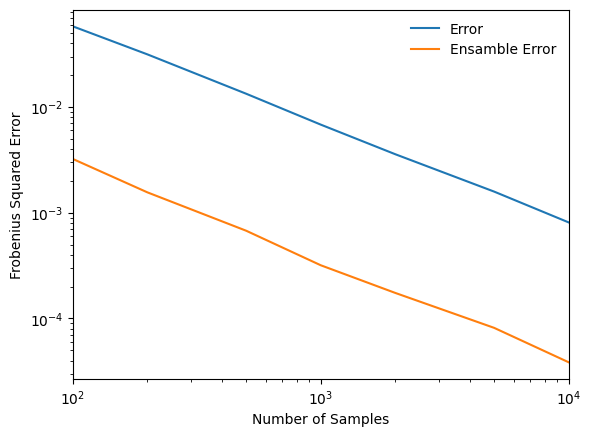

In [8]:
fig, ax = plt.subplots()
ax.plot(n_samples, err, label="Error")
ax.plot(n_samples, ensamble_err, label="Ensamble Error")
ax.set_ylabel("Frobenius Squared Error")
ax.set_xlabel("Number of Samples")
ax.set_xscale('log')
ax.set_yscale('log')
ax.margins(x=0)
ax.legend(frameon=False)

In [9]:
lin_sys.A

array([[ 0.02200192, -0.04588285, -0.03554529, -0.02955978,  0.01467418,
        -0.02515903,  0.03406454,  0.02744921, -0.0239559 ,  0.01949852,
        -0.02498381, -0.01033115, -0.00366044, -0.06129716, -0.03256095,
         0.05989786,  0.0357117 , -0.00255343, -0.016006  ,  0.02477388],
       [-0.04588285,  0.0968588 ,  0.07509121,  0.06161969, -0.03038475,
         0.05258784, -0.07040633, -0.05729579,  0.04949243, -0.03918475,
         0.05229513,  0.02182854,  0.00593514,  0.1292986 ,  0.06918165,
        -0.12544367, -0.07395392,  0.00530646,  0.03457126, -0.05320868],
       [-0.03554529,  0.07509121,  0.05825494,  0.04768261, -0.02344497,
         0.04066639, -0.05442948, -0.04432529,  0.0382069 , -0.03006222,
         0.04052401,  0.01696838,  0.00432603,  0.10024581,  0.05372702,
        -0.0971583 , -0.05716082,  0.00409836,  0.0269577 , -0.04141927],
       [-0.02955978,  0.06161969,  0.04768261,  0.03979103, -0.0198416 ,
         0.0339154 , -0.04590121, -0.03697088,  